# Feb 17, 2025: roi profile variability
nature of profiles: 
- localized/distributed: focused/distributed within modes?
- low/high variability across solution modes: consistent/variable between modes?

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.spatial.distance import jensenshannon
from multiprocessing import Pool
import glob
import random
import re

from sklearn.cluster import DBSCAN, KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.utils import resample

import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.source ='allen' #'spatial' #'allen'
args.space = 'ccfv2' #'yale' #'ccfv2'
args.brain_div = 'whl' #'whl' #'whl'
args.num_rois = 172 #216 #162 #172
args.resolution = 200 #200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
SYS_path = f'{BASE_path}/canonical_systems/joanes/space-{args.space}'

In [6]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [7]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    num_rois = num_rois
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

In [8]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids
marginals_df

sub       sbm                                       pi_0_aligned  \
0   SLC01  sbm-nd-h  [[0.9482758620689655, 0.0, 0.0, 0.0, 0.0, 0.02...   
1   SLC01  sbm-nd-h  [[0.9823008849557522, 0.0, 0.0, 0.0, 0.0, 0.00...   
2   SLC01  sbm-nd-h  [[0.728476821192053, 0.0, 0.0, 0.0, 0.0, 0.059...   
3   SLC01  sbm-nd-h  [[0.8666666666666665, 0.0, 0.0, 0.0, 0.0, 0.01...   
4   SLC01  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5   SLC01  sbm-nd-h  [[0.8095238095238095, 0.0, 0.0, 0.0, 0.0, 0.04...   
6   SLC03  sbm-nd-h  [[0.999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, ...   
7   SLC04  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8   SLC04  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9   SLC04  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
10  SLC04  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
11  SLC04  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
12  SLC05  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
13  SLC05  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
14  SLC05  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
15  SLC05  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
16  SLC05  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
17  SLC05  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
18  SLC05  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
19  SLC05  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
20  SLC06  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
21  SLC06  sbm-nd-h  [[0.005154639175257732, 0.0, 0.0, 0.0, 0.0, 0....   
22  SLC06  sbm-nd-h  [[0.006289308176100629, 0.0, 0.0, 0.0, 0.0, 0....   
23  SLC06  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
24  SLC06  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
25  SLC06  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
26  SLC06  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
27  SLC07  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
28  SLC07  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
29  SLC07  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
30  SLC07  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
31  SLC07  sbm-nd-h  [[0.0, 0.0, 0.9696969696969697, 0.0, 0.0, 0.0,...   
32  SLC08  sbm-nd-h  [[0.008064516129032258, 0.0, 0.0, 0.0, 0.0, 0....   
33  SLC08  sbm-nd-h  [[0.004608294930875576, 0.0, 0.0, 0.0, 0.0, 0....   
34  SLC08  sbm-nd-h  [[0.014925373134328358, 0.0, 0.0, 0.0, 0.0, 0....   
35  SLC08  sbm-nd-h  [[0.02142857142857143, 0.0, 0.0357142857142857...   
36  SLC08  sbm-nd-h  [[0.9285714285714286, 0.0, 0.0, 0.0, 0.0, 0.0,...   
37  SLC09  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
38  SLC09  sbm-nd-h  [[0.00425531914893617, 0.0, 0.0, 0.0, 0.0, 0.0...   
39  SLC09  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
40  SLC09  sbm-nd-h  [[0.007518796992481203, 0.0, 0.0, 0.0, 0.0, 0....   
41  SLC09  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
42  SLC09  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
43  SLC09  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
44  SLC10  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
45  SLC10  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
46  SLC10  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
47  SLC10  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         pi_1_aligned  \
0   [[0.8970273483947682, 0.0021403091557669444, 0...   
1   [[0.9442203774767014, 0.00035241600751820815, ...   
2   [[0.9580959367810823, 0.0035724110983968013, 0...   
3   [[0.9538888888888887, 0.004374999999999999, 0....   
4   [[0.9813084112149533, 0.0, 0.00934579439252336...   
5   [[0.989750566893424, 0.0015419501

In [9]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols

['pi_0_aligned',
 'pi_1_aligned',
 'pi_2_aligned',
 'pi_3_aligned',
 'pi_4_aligned',
 'pi_5_aligned',
 'pi_6_aligned',
 'pi_7_aligned',
 'pi_8_aligned']

In [10]:
# SOFT MARGINALS
soft_marginals_df = []
for sub, group in marginals_df.groupby('sub'):
    omegas = group['omega'].to_list()
    dct = {'sub': [sub], 'sbm': [SBM]}
    for col in cols:
        M = get_membership_matrix(args.num_rois, group, col=col)
        SCs = np.average(M, axis=1, weights=omegas) # soft-comms.
        dct[col] = [SCs]
    soft_marginals_df += [pd.DataFrame(dct)]
soft_marginals_df = pd.concat(soft_marginals_df).reset_index(drop=True)
soft_marginals_df

sub       sbm                                       pi_0_aligned  \
0  SLC01  sbm-nd-h  [[0.9038268712699686, 0.0, 0.0, 0.0, 0.0, 0.02...   
1  SLC03  sbm-nd-h  [[0.999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, ...   
2  SLC04  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  SLC05  sbm-nd-h  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  SLC06  sbm-nd-h  [[0.0019990429877455754, 0.0, 0.0, 0.0, 0.0, 0...   
5  SLC07  sbm-nd-h  [[0.0, 0.0, 0.9990094988694709, 0.0, 0.0, 0.0,...   
6  SLC08  sbm-nd-h  [[0.07519429960687783, 0.0, 0.0049952847712399...   
7  SLC09  sbm-nd-h  [[0.001997019572506654, 0.0, 0.0, 0.0, 0.0, 0....   
8  SLC10  sbm-nd-h  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                        pi_1_aligned  \
0  [[0.9425535313557556, 0.0019284680340845208, 0...   
1  [[0.6873119999999999, 0.0, 0.000999, 0.0, 0.00...   
2  [[0.05096483941849146, 0.1837414993759305, 0.1...   
3  [[0.01698585548920685, 0.6931202178030339, 0.2...   
4  [[0.9629839720871994, 0.0, 0.0, 0.0, 0.0370160...   
5  [[0.0, 0.01992179833440278, 0.9800782016655971...   
6  [[0.084910126389941, 0.7861843046015143, 0.122...   
7  [[0.2166924526164383, 0.0, 6.007652018420958e-...   
8  [[0.020377111062453115, 2.278781163434903e-05,...   

                                        pi_2_aligned  \
0  [[0.8999964798564869, 0.08177521066034947, 0.0...   
1  [[0.6259628728201437, 0.287023076676259, 0.016...   
2  [[0.8687950961728368, 0.12113627885961116, 0.0...   
3  [[0.8717267055866504, 0.12221944425091172, 0.0...   
4  [[0.9063316130955903, 0.07035996191741896, 0.0...   
5  [[0.8715145139081502, 0.1273032488155092, 0.0,...   
6  [[0.8724100606880105, 0.10482624787319553, 0.0...   
7  [[0.9324570546390136, 0.053593115251743095, 0....   
8  [[0.9657609609566022, 0.032236299939342794, 0....   

                                        pi_3_aligned  \
0  [[0.9881737990709383, 0.011826200929061718], [...   
1  [[0.9611146297223375, 0.038826089952122576, 0....   
2  [[0.973779734080982, 0.025844442853176504, 0.0...   
3  [[0.9753352291218292, 0.0246647708781708], [0....   
4  [[0.9838355609548627, 0.015190285430517739, 0....   
5  [[0.9770973721084645, 0.022902627891535472], [...   
6  [[0.9837286332039543, 0.015560396413013856, 0....   
7  [[0.9901780657754935, 0.008842662083801469, 0....   
8  [[0.9921189498621988, 0.00788101151439179, 0.0...   

                                        pi_4_aligned  \
0  [[0.9982864493080832, 0.0017135506919168648], ...   
1  [[0.9921222426184096, 0.007877757381590087], [...   
2  [[0.9967195524668677, 0.003280447533132399], [...   
3  [[0.9932073795269443, 0.006792620473055691], [...   
4  [[0.9960760624998158, 0.003923937500184351], [...   
5  [[0.993556629939218, 0.006443370060781979], [0...   
6  [[0.9974851854775922, 0.0025148145224077635], ...   
7  [[0.9995640476373562, 0.0004359523626439976], ...   
8  [[0.9984586553806662, 0.001541344619333896], [...   

                                        pi_5_aligned  \
0  [[0.9997101233867878, 0.0002898766132122867], ...   
1  [[0.9983119091325161, 0.0016880908674835901], ...   
2  [[0.9980693657328856, 0.0019306342671144008], ...   
3  [[0.9984491948578383, 0.0015508051421614733], ...   
4  [[0.9979193325072813, 0.0020806674927187647], ...   
5  [[0.9981191105252368, 0.0018808894747630335], ...   
6  [[0.9994721384068656, 0.0005278615931344853], ...   
7  [[0.999818847611407, 0.00018115238859311297], ...   
8  [[0.999634633598244, 0.0003653664017562252], [...   

                                        pi_6_aligned  \
0  [[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....   
1  [[0.9999999999999997], [1.0000000000000002], [...   
2  [[1.0000000000000002], [1.0], [1.0], [1.0], [0...   
3  [[0.9999999999999999], [1.0], [0.9999999999999...   
4  [[0.9996359080493212, 0.00036409195067891296],...   
5  [[0.9999999999999998], [0.9999999999999999], [...   
6  [[0.9998181641999292, 0.00018183580007093359],...   
7  [[1.0], [1.0], [1.

entropies

In [11]:
def mem_entropy(pi):
    if isinstance(pi, np.ndarray):
        ent = stats.entropy(pi, base=2, axis=-1) / np.log2(pi.shape[-1])
        ent = np.nan_to_num(ent)
    elif np.isnan(pi):
        ent = np.zeros((args.num_rois,))
    return ent

In [12]:
marginals_ent_df = pd.concat(
    [
        marginals_df[['sub', 'sbm']],
        marginals_df[cols].applymap(mem_entropy), 
        marginals_df[['omega', 'mode_id']],
    ],
    axis=1
)
marginals_ent_df

sub       sbm                                       pi_0_aligned  \
0   SLC01  sbm-nd-h  [0.07008468716032477, 0.0, 0.01351739918284669...   
1   SLC01  sbm-nd-h  [0.02936982135142421, 0.0, 0.0, 0.0, 0.0150404...   
2   SLC01  sbm-nd-h  [0.23081224203031991, 0.0, 0.10215589588957343...   
3   SLC01  sbm-nd-h  [0.1404483064957667, 0.0, 0.03944402572595913,...   
4   SLC01  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.0, 0.04737827110456024,...   
5   SLC01  sbm-nd-h  [0.19566939268978653, 0.0, 0.01581847192514149...   
6   SLC03  sbm-nd-h  [0.0022240452904966957, 0.0, 0.015785095885408...   
7   SLC04  sbm-nd-h  [0.0, 0.0, 0.1859026449333606, 0.0, 0.00367449...   
8   SLC04  sbm-nd-h  [0.0, 0.0, 0.1105442485530929, 0.0, 0.01771342...   
9   SLC04  sbm-nd-h  [0.0, 0.0, 0.12720312354784308, 0.0, 0.0, 0.21...   
10  SLC04  sbm-nd-h  [0.0, 0.0, 0.061908685830065036, 0.0, 0.0, 0.1...   
11  SLC04  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12  SLC05  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.047634643705108434, 0.0...   
13  SLC05  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.008330968503162672, 0.0...   
14  SLC05  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.0, 0.044027932513967256...   
15  SLC05  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.0, 0.02773921431832003,...   
16  SLC05  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.0, 0.019173942642388538...   
17  SLC05  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.0, 0.02651865914139364,...   
18  SLC05  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.0, 0.04758726251380744,...   
19  SLC05  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.114...   
20  SLC06  sbm-nd-h  [0.0, 0.0, 0.006476668610684782, 0.16918860431...   
21  SLC06  sbm-nd-h  [0.009495255802423795, 0.0, 0.0094952558024237...   
22  SLC06  sbm-nd-h  [0.011216458572046813, 0.0, 0.0112164585720468...   
23  SLC06  sbm-nd-h  [0.0, 0.0, 0.01127567121375633, 0.122000134788...   
24  SLC06  sbm-nd-h  [0.0, 0.0, 0.0, 0.19786751032722671, 0.1547247...   
25  SLC06  sbm-nd-h  [0.0, 0.04189873488703428, 0.06601720758076951...   
26  SLC06  sbm-nd-h  [0.0, 0.16390262228822006, 0.0, 0.314690683753...   
27  SLC07  sbm-nd-h  [0.0, 0.0, 0.07244683185051772, 0.043245579534...   
28  SLC07  sbm-nd-h  [0.0, 0.0, 0.06202108335922866, 0.043907403971...   
29  SLC07  sbm-nd-h  [0.0, 0.0, 0.06261976986724614, 0.039616097820...   
30  SLC07  sbm-nd-h  [0.0, 0.0, 0.08303517989240361, 0.042968616522...   
31  SLC07  sbm-nd-h  [0.03992533908315305, 0.06722099541048379, 0.0...   
32  SLC08  sbm-nd-h  [0.019251723955931496, 0.0, 0.0054673570994364...   
33  SLC08  sbm-nd-h  [0.016153100114718124, 0.0, 0.0, 0.01439686589...   
34  SLC08  sbm-nd-h  [0.03200119000180425, 0.0, 0.03200119000180425...   
35  SLC08  sbm-nd-h  [0.07479239732244602, 0.0, 0.05152038740472516...   
36  SLC08  sbm-nd-h  [0.07565530948929543, 0.0, 0.12057998177335605...   
37  SLC09  sbm-nd-h  [0.0, 0.01836092460086448, 0.03195916614370671...   
38  SLC09  sbm-nd-h  [0.007609846542347137, 0.023874317595844907, 0...   
39  SLC09  sbm-nd-h  [0.0, 0.04266951157529961, 0.0117462464902886,...   
40  SLC09  sbm-nd-h  [0.012167409953290558, 0.03711346645811365, 0....   
41  SLC09  sbm-nd-h  [0.0, 0.09689414504223698, 0.06540440637736641...   
42  SLC09  sbm-nd-h  [0.0, 0.019610125907388094, 0.0340514523762476...   
43  SLC09  sbm-nd-h  [0.0, 0.0, 0.0, 0.03805292996875361, 0.0599316...   
44  SLC10  sbm-nd-h  [0.03230222046045495, 0.0, 0.0, 0.0, 0.0767982...   
45  SLC10  sbm-nd-h  [0.07726213331895909, 0.0, 0.0, 0.0, 0.0, 0.24...   
46  SLC10  sbm-nd-h  [0.15804048659210018, 0.0, 0.0, 0.0, 0.1637779...   
47  SLC10  sbm-nd-h  [0.06223912372379411, 0.0, 0.0, 0.0, 0.0622391...   

                                         pi_1_aligned  \
0   [0.1649708130987153, 0.22557962890217065, 0.14...   
1   [0.09546441721401544, 0.2557305853243463, 0.16...   
2   [0.08329313566825852, 0.22060171386470223, 0.2...   
3   [0.08492420662821108, 0.1693517951856861, 0.21...   
4   [0.040112200748163414, 0.2016991200834702, 0.2...   
5   [0.025263685808841183, 0.14116624

In [13]:
soft_marginals_ent_df = pd.concat(
    [
        soft_marginals_df[['sub', 'sbm']],
        soft_marginals_df[cols].applymap(mem_entropy)
    ],
    axis=1,
)
soft_marginals_ent_df

sub       sbm                                       pi_0_aligned  \
0  SLC01  sbm-nd-h  [0.1159892997486691, 0.0, 0.0327170182065308, ...   
1  SLC03  sbm-nd-h  [0.0022240452904966957, 0.0, 0.015785095885408...   
2  SLC04  sbm-nd-h  [0.0, 0.0, 0.21037864195430897, 0.0, 0.0087119...   
3  SLC05  sbm-nd-h  [0.0, 0.0, 0.0, 0.0, 0.016430133847345377, 0.0...   
4  SLC06  sbm-nd-h  [0.0042400565078347585, 0.024132002703235626, ...   
5  SLC07  sbm-nd-h  [0.00230554200983867, 0.004207076829523884, 0....   
6  SLC08  sbm-nd-h  [0.08744775208410893, 0.0, 0.02914081378861403...   
7  SLC09  sbm-nd-h  [0.0039610598295644435, 0.03671961660695934, 0...   
8  SLC10  sbm-nd-h  [0.06286021918775338, 0.0, 0.0, 0.0, 0.1792555...   

                                        pi_1_aligned  \
0  [0.09914997859085468, 0.20855991503783977, 0.1...   
1  [0.20751712081291726, 0.004667426953810169, 0....   
2  [0.5534808234346594, 0.01180555523755857, 0.30...   
3  [0.2585190176645956, 0.2406533471384369, 0.258...   
4  [0.0660337905429385, 0.08089276820550013, 0.09...   
5  [0.03703390947449487, 0.06484707374331909, 0.0...   
6  [0.2192399380211247, 0.1392903056685648, 0.154...   
7  [0.39335995548456754, 0.2224454835544197, 0.37...   
8  [0.057020801269236664, 0.314237435181107, 0.18...   

                                        pi_2_aligned  \
0  [0.18135967210755713, 0.23394942098035995, 0.2...   
1  [0.4000262628115279, 0.3648210137129775, 0.382...   
2  [0.19702894390368164, 0.21408858650407345, 0.2...   
3  [0.19671867841010182, 0.1985363181159228, 0.19...   
4  [0.167294007907887, 0.2502181946739006, 0.2089...   
5  [0.20053191831757125, 0.19855699719312908, 0.2...   
6  [0.20305229032218056, 0.20535609665664692, 0.2...   
7  [0.12928176058192245, 0.2693217666173381, 0.25...   
8  [0.08058503380041362, 0.14198824121573503, 0.1...   

                                        pi_3_aligned  \
0  [0.09267010937604211, 0.1208998627094217, 0.12...   
1  [0.10241414289675511, 0.07947882748633915, 0.0...   
2  [0.07662044310525597, 0.07990651776390782, 0.0...   
3  [0.16688577046804723, 0.16902954797195333, 0.1...   
4  [0.07863651397939837, 0.12926755808826854, 0.1...   
5  [0.15744159029007576, 0.15516623853405048, 0.1...   
6  [0.062086628009235416, 0.06267324172266502, 0....   
7  [0.053129034271274085, 0.12089546449230103, 0....   
8  [0.03319689429487629, 0.05973354326335055, 0.0...   

                                        pi_4_aligned  \
0  [0.01821547855151417, 0.026696970119911505, 0....   
1  [0.06637008040050589, 0.049625655590191095, 0....   
2  [0.031794811788738116, 0.03172538847242759, 0....   
3  [0.058685524554955265, 0.05910039168007998, 0....   
4  [0.03701584847019957, 0.06714425300516184, 0.0...   
5  [0.056160451764384056, 0.05534227690964206, 0....   
6  [0.025339803635477706, 0.025627550585366296, 0...   
7  [0.005495581655344201, 0.024402492984975387, 0...   
8  [0.01662059253867229, 0.035969423462449884, 0....   

                                        pi_5_aligned  \
0  [0.0038248521538971876, 0.006057547573586073, ...   
1  [0.017981321725976166, 0.013284270411837761, 0...   
2  [0.020190594169523526, 0.019886883963182875, 0...   
3  [0.016708905990425283, 0.016822823919556026, 0...   
4  [0.021534764920908587, 0.037187772538297234, 0...   
5  [0.019741264118815417, 0.01951436023155323, 0....   
6  [0.006508463175202029, 0.006676644625706385, 0...   
7  [0.0025131402947879645, 0.008373841534514691, ...   
8  [0.004698904168189435, 0.011158282284646595, 0...   

                                        pi_6_aligned  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.004684349476538322, 0.006711601829893602, 0...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6  [0.0025216334105853163, 0.002688014198567334, ...   
7  [0.0, 0.0, 0.0, 0.

In [14]:
entropies_df = []
for sub, group in marginals_ent_df.groupby('sub'):
    for col in cols:
        omegas = group['omega'].to_numpy()
        Hs = np.stack(group[col].to_list(), axis=-1)
        avg_H = Hs @ omegas
        H_mix = soft_marginals_ent_df[soft_marginals_ent_df['sub'] == sub][col].to_list()[0]
        del_H = H_mix - avg_H
        row = pd.DataFrame(dict(
            sub=[sub],
            sbm=[SBM],
            col=[col],
            average_H=[avg_H],
            H_mixture=[H_mix],
            delta_H=[del_H],
        ))
        entropies_df += [row]
entropies_df = pd.concat(entropies_df).reset_index(drop=True)

In [15]:
entropies_df

sub       sbm           col  \
0   SLC01  sbm-nd-h  pi_0_aligned   
1   SLC01  sbm-nd-h  pi_1_aligned   
2   SLC01  sbm-nd-h  pi_2_aligned   
3   SLC01  sbm-nd-h  pi_3_aligned   
4   SLC01  sbm-nd-h  pi_4_aligned   
..    ...       ...           ...   
76  SLC10  sbm-nd-h  pi_4_aligned   
77  SLC10  sbm-nd-h  pi_5_aligned   
78  SLC10  sbm-nd-h  pi_6_aligned   
79  SLC10  sbm-nd-h  pi_7_aligned   
80  SLC10  sbm-nd-h  pi_8_aligned   

                                            average_H  \
0   [0.09937972086898217, 0.0, 0.02578029736680561...   
1   [0.09920483715088138, 0.2134621483729327, 0.17...   
2   [0.1859121255138549, 0.24061343742250627, 0.24...   
3   [0.09020911330432234, 0.1168801274642916, 0.11...   
4   [0.016759160495920186, 0.02442072795279198, 0....   
..                                                ...   
76  [0.016327999990096462, 0.035167617290772044, 0...   
77  [0.004119646423353244, 0.009743392446855324, 0...   
78  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
79  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
80  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            H_mixture  \
0   [0.1159892997486691, 0.0, 0.0327170182065308, ...   
1   [0.09914997859085468, 0.20855991503783977, 0.1...   
2   [0.18135967210755713, 0.23394942098035995, 0.2...   
3   [0.09267010937604211, 0.1208998627094217, 0.12...   
4   [0.01821547855151417, 0.026696970119911505, 0....   
..                                                ...   
76  [0.01662059253867229, 0.035969423462449884, 0....   
77  [0.004698904168189435, 0.011158282284646595, 0...   
78  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
79  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
80  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              delta_H  
0   [0.016609578879686934, 0.0, 0.0069367208397251...  
1   [-5.4858560026696535e-05, -0.00490223333509293...  
2   [-0.004552453406297757, -0.006664016442146314,...  
3   [0.002460996071719776, 0.004019735245130093, 0...  
4   [0.0014563180555939859, 0.0022762421671195243,...  
..                                                ...  
76  [0.00029259254857582837, 0.0008018061716778407...  
77  [0.0005792577448361907, 0.0014148898377912712,...  
78  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
79  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
80  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[81 rows x 6 columns]

In [16]:
for sub, group in entropies_df.groupby('sub'):
    folder = f'{ESTIM_path}/individual/sub-{sub}/consistency-of-comm-assignments/{SBM}'
    os.system(f'mkdir -p {folder}')
    with open(f'{folder}/desc-entropies.pkl', 'wb') as f:
        pickle.dump(group, f)

nature of variability/consistency

In [17]:
def get_kmeans_threshold(data):
    kmeans = KMeans(n_clusters=2).fit(data.reshape(-1,1))
    centers = kmeans.cluster_centers_.flatten()
    return np.mean(centers)

def get_percentile_threshold(data):
    return np.percentile(data, q=66)

def get_membership_variability_type(avg_H, del_H, avg_H_thresh, del_H_thresh):
    var_types = np.stack([avg_H > avg_H_thresh, del_H > del_H_thresh], axis=-1) @ [2, 1] # converting a base 2 number to base 10 number.
    var_types = var_types.reshape(-1, 1)
    var_types = OneHotEncoder(sparse_output=False, categories=[np.array([0, 1, 2, 3])]).fit_transform(var_types)
    return var_types

def get_var_types_per_sub(sub, group, avg_H_thresh=0.15, del_H_thresh=0.15):
    dct = {'sub':[sub], 'sbm':[SBM]}
    for idx, row in group.iterrows():
        col = row['col']
        avg_H, del_H = row[['average_H', 'delta_H']]
        avg_H_thresh = get_kmeans_threshold(avg_H) #get_percentile_threshold(avg_H)
        del_H_thresh = get_kmeans_threshold(del_H) #get_percentile_threshold(del_H)
        var_types = get_membership_variability_type(
            avg_H, del_H, avg_H_thresh, del_H_thresh
        )
        dct[col] = [var_types]
    return pd.DataFrame(dct)

<Axes: ylabel='Density'>

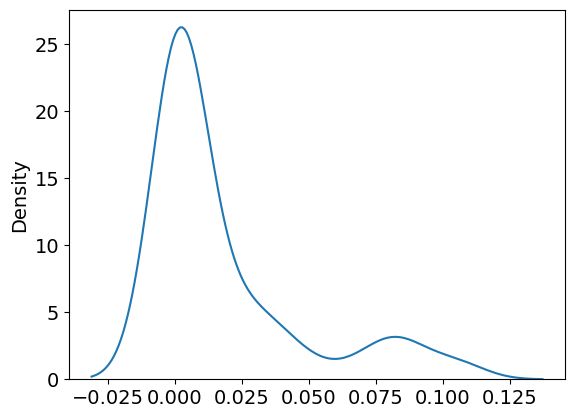

In [18]:
for idx, row in entropies_df.iterrows():
    if not (row['sub'] == 'SLC01' and row['col'] == 'pi_0_aligned'): continue
    avg_H, H_mix, del_H = row[['average_H', 'H_mixture', 'delta_H']]
    # break
sns.kdeplot(del_H)

In [19]:
data = avg_H

thresh = get_kmeans_threshold(data)
# thresh = np.median(del_H)
# del_H_thresh = np.percentile(data, q=66)
print(f'kmeans', thresh, np.sum(data < thresh), np.sum(data >= thresh))

# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=2)
# gmm.fit(del_H.reshape(-1, 1))
# labels = gmm.predict(del_H.reshape(-1, 1))
# np.sum(labels == 0), np.sum(labels == 1)

from skimage.filters import threshold_otsu, threshold_isodata
threshold = threshold_isodata(data)
print(f'otsu', threshold, np.sum(data < threshold), np.sum(data >= threshold))

kmeans 0.10830439003175467 133 39
otsu 0.09823098912727896 126 46


In [20]:
var_types_df = []
for sub, group in entropies_df.groupby('sub'):
    row = get_var_types_per_sub(sub, group)
    var_types_df += [row]
var_types_df = pd.concat(var_types_df).reset_index(drop=True)

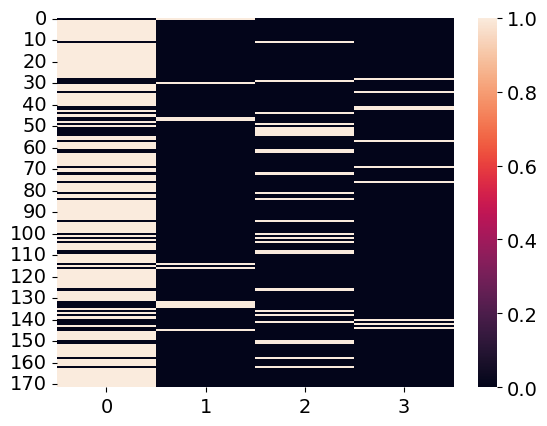

In [21]:
col = cols[0]
if args.sbm in ['h']:
    Xs = get_membership_matrix(args.num_rois, var_types_df, col=col)
    sns.heatmap(Xs[:, 6, :])
    Xs.shape

In [22]:
var_types_df

sub       sbm                                       pi_0_aligned  \
0  SLC01  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
1  SLC03  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
2  SLC04  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
3  SLC05  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
4  SLC06  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
5  SLC07  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
6  SLC08  sbm-nd-h  [[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
7  SLC09  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
8  SLC10  sbm-nd-h  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   

                                        pi_1_aligned  \
0  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
1  [[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
2  [[0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [...   
3  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
4  [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...   
5  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
6  [[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
7  [[0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0], [...   
8  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   

                                        pi_2_aligned  \
0  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
1  [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
2  [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [...   
3  [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
4  [[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
5  [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
6  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
7  [[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
8  [[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   

                                        pi_3_aligned  \
0  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
1  [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
2  [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [...   
3  [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...   
4  [[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
5  [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
6  [[0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...   
7  [[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
8  [[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   

                                        pi_4_aligned  \
0  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
1  [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
2  [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...   
3  [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...   
4  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
5  [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
6  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
7  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
8  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   

                                        pi_5_aligned  \
0  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
1  [[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
2  [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...   
3  [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...   
4  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
5  [[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...   
6  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
7  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
8  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   

                                        pi_6_aligned  \
0  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
1  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
2  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
3  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
4  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
5  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
6  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
7  [[1.0, 0.0, 0.0, 0

In [23]:
for idx, row in var_types_df.iterrows():
    sub = row['sub']
    folder = f'{ESTIM_path}/individual/sub-{sub}/consistency-of-comm-assignments/{SBM}'
    os.system(f'mkdir -p {folder}')
    with open(f'{folder}/desc-var-types.pkl', 'wb') as f:
        pickle.dump(row, f)

save individual level estimates

In [24]:
parcels_img = ants.image_read(f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz')

def get_roi_name(s):
    match = re.match(r'([RL]-[^\(]+)\s\(([^)]+)\)', s)
    return ''.join([match.group(1)[:2], match.group(2)])

try:
    roi_labels = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')['roi'].to_list()
    df = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')['name']
    roi_names = df.apply(get_roi_name)
except:
    roi_labels = np.arange(1, args.num_rois+1)
    roi_names = roi_labels

In [25]:
def concatenate(in_files, out_file):
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = in_files
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline 
    tcat.run()

    for file in in_files:
        try:
            os.remove(file)
        except:
            pass
    return None

def ents_to_nifti(args, parcels_img, X, folder, ent_names, col=f'col'):
    parcels_vol = parcels_img.numpy()
    parcels_vol = np.round(parcels_vol, decimals=0)

    os.system(f'mkdir -p {folder}')
    in_files = []
    for idx_ent in range(X.shape[-1]):
        x = X[:, idx_ent]
        x_img = np.zeros_like(parcels_vol)
        for idx, roi in enumerate(roi_labels):
            x_img += (parcels_vol == roi) * (x[idx])
        
        file = f'{folder}/ent-{ent_names[idx_ent]}.nii.gz'
        parcels_img.new_image_like(x_img).to_filename(file)
        in_files.append(file)
    
    out_file = f'{folder}/{col}_desc-entropies.nii.gz'
    concatenate(in_files, out_file)
    return None

def var_types_to_nifti(args, parcels_img, X, folder, col=f'col'):
    parcels_vol = parcels_img.numpy()
    parcels_vol = np.round(parcels_vol, decimals=0)

    os.system(f'mkdir -p {folder}')
    in_files = []
    for idx_type in range(0, 4):
        x = X[:, idx_type]
        x_img = np.zeros_like(parcels_vol)
        for idx, roi in enumerate(roi_labels):
            x_img += (parcels_vol == roi) * (x[idx])
        
        file = f'{folder}/vartype-{idx_type:01d}.nii.gz'
        parcels_img.new_image_like(x_img).to_filename(file)
        in_files.append(file)

    out_file = f'{folder}/{col}_desc-var-types.nii.gz'
    concatenate(in_files, out_file)
    return None

In [26]:
# save all entropies per animal
for idx_row, row in entropies_df.iterrows():
    sub, col = row[['sub', 'col']]

    out_folder = f'{ESTIM_path}/individual/sub-{sub}/consistency-of-comm-assignments/{SBM}/visuals/res-{args.resolution}/nii'
    os.system(f'mkdir -p {out_folder}')

    Hs = np.stack(row[['average_H', 'H_mixture', 'delta_H']], axis=-1)
    ents_to_nifti(
        args, 
        parcels_img,
        Hs, 
        out_folder, 
        ent_names=['avgH', 'Hmix', 'delH'],
        col=col,
    )
    # break

250405-22:31:58,621 nipype.interface INFO:
	 stderr 2025-04-05T22:31:58.621292:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250405-22:31:58,624 nipype.interface INFO:
	 stderr 2025-04-05T22:31:58.624030:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250405-22:31:58,626 nipype.interface INFO:
	 stderr 2025-04-05T22:31:58.626581:*+ WARNING: Set TR of output dataset to 1.0 s
250405-22:31:58,673 nipype.interface INFO:
	 stderr 2025-04-05T22:31:58.673397:++ elapsed time = 0.1 s
250405-22:31:59,64 nipype.interface INFO:
	 stderr 2025-04-05T22:31:59.064285:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250405-22:31:59,67 nipype.interface INFO:
	 stderr 2025-04-05T22:31:59.067034:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250405-22:31:59,69 nipype.interface INFO:
	 stderr 2025-04-05T22:31:59.069349:*+ WARNING: Set TR of output dataset to 1.0 s
250405-22:31:59,118 nipype.interface INFO:
	 stderr 2025-04-05

In [27]:
# save all var_types per animal
for idx, row in var_types_df.iterrows():
    sub = row['sub']

    out_folder = f'{ESTIM_path}/individual/sub-{sub}/consistency-of-comm-assignments/{SBM}/visuals/res-{args.resolution}/nii'
    os.system(f'mkdir -p {out_folder}')

    for col in cols:
        X = row[col]
        var_types_to_nifti(args, parcels_img, X, out_folder, col=col)
        # break
    # break

250405-22:32:33,971 nipype.interface INFO:
	 stderr 2025-04-05T22:32:33.971796:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250405-22:32:33,975 nipype.interface INFO:
	 stderr 2025-04-05T22:32:33.975055:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250405-22:32:33,977 nipype.interface INFO:
	 stderr 2025-04-05T22:32:33.977610:*+ WARNING: Set TR of output dataset to 1.0 s
250405-22:32:34,27 nipype.interface INFO:
	 stderr 2025-04-05T22:32:34.027213:++ elapsed time = 0.1 s
250405-22:32:34,432 nipype.interface INFO:
	 stderr 2025-04-05T22:32:34.432376:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250405-22:32:34,435 nipype.interface INFO:
	 stderr 2025-04-05T22:32:34.435212:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250405-22:32:34,436 nipype.interface INFO:
	 stderr 2025-04-05T22:32:34.436864:*+ WARNING: Set TR of output dataset to 1.0 s
250405-22:32:34,473 nipype.interface INFO:
	 stderr 2025-04-

group level aggregation

In [28]:
# entropies

In [29]:
def bootstrap(matrices, statistic=np.median, n_bootstrap=1000):
    stacked = np.stack(matrices)
    bootstrap_stats = np.stack([
        statistic(resample(stacked), axis=0)
        for _ in range(n_bootstrap)
    ])
    return (
        statistic(bootstrap_stats, axis=0), # mean := probability of var type per roi
        np.percentile(bootstrap_stats, [2.5, 97.5], axis=0) # CI
    )

In [30]:
group_ents_df = []
grp_cols = ['average_H', 'H_mixture', 'delta_H']
for col, group in entropies_df.groupby('col'):
    dct = {'sbm':[SBM], 'col':[col]}
    for grp_col in grp_cols:
        Hs = group[grp_col].to_list()
        mean_H, ci = bootstrap(Hs, n_bootstrap=100)
        dct[f'{grp_col}_stat'] = [mean_H]
        dct[f'{grp_col}_cil'] = [ci[0]]
        dct[f'{grp_col}_ciu'] = [ci[1]]
    row = pd.DataFrame(dct)
    group_ents_df += [row]
group_ents_df = pd.concat(group_ents_df).reset_index(drop=True)

In [31]:
group_ents_df

sbm           col                                     average_H_stat  \
0  sbm-nd-h  pi_0_aligned  [0.0034017954287714567, 0.0, 0.024132194727504...   
1  sbm-nd-h  pi_1_aligned  [0.16586652306103492, 0.1395355180555287, 0.15...   
2  sbm-nd-h  pi_2_aligned  [0.21234867001860308, 0.2466211492843429, 0.24...   
3  sbm-nd-h  pi_3_aligned  [0.10170579194113934, 0.1168801274642916, 0.11...   
4  sbm-nd-h  pi_4_aligned  [0.030683708180569425, 0.035167617290772044, 0...   
5  sbm-nd-h  pi_5_aligned  [0.01398386710201878, 0.013284270411837761, 0....   
6  sbm-nd-h  pi_6_aligned  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7  sbm-nd-h  pi_7_aligned  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8  sbm-nd-h  pi_8_aligned  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                       average_H_cil  \
0  [0.0, 0.0, 0.0, 0.0, 0.003049734906764417, 0.0...   
1  [0.0623694404534895, 0.03794176404388253, 0.09...   
2  [0.15649678970099765, 0.2154015686538691, 0.21...   
3  [0.082522804361651, 0.08494825125631131, 0.085...   
4  [0.016759160495920186, 0.024467729500454834, 0...   
5  [0.004119646423353244, 0.0069418274247102785, ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                       average_H_ciu  \
0  [0.05869239633693567, 0.011941551597439357, 0....   
1  [0.2586068495401696, 0.2219025360394161, 0.176...   
2  [0.2655087709285694, 0.30280347761050874, 0.29...   
3  [0.15518227242243257, 0.1646459498600035, 0.15...   
4  [0.055647811456878256, 0.05670820960681315, 0....   
5  [0.017981321725976166, 0.01769346244737653, 0....   
6  [0.000957865089439843, 0.0010181354079756239, ...   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                      H_mixture_stat  \
0  [0.0039610598295644435, 0.0, 0.029140813788614...   
1  [0.20751712081291726, 0.1392903056685648, 0.17...   
2  [0.19671867841010182, 0.21408858650407345, 0.2...   
3  [0.07863651397939837, 0.12089546449230103, 0.1...   
4  [0.031794811788738116, 0.035969423462449884, 0...   
5  [0.016708905990425283, 0.013284270411837761, 0...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                       H_mixture_cil  \
0  [0.0022240452904966957, 0.0, 0.006482677486508...   
1  [0.057020801269236664, 0.01180555523755857, 0....   
2  [0.14733757806175563, 0.19854614067759577, 0.1...   
3  [0.05738389129680572, 0.06267324172266502, 0.0...   
4  [0.017378163394772186, 0.025627550585366296, 0...   
5  [0.0038248521538971876, 0.006676644625706385, ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                       H_mixture_ciu  \
0  [0.08744775208410893, 0.01466766291322238, 0.0...   
1  [0.2585190176645956, 0.2406533471384369, 0.258...   
2  [0.20053191831757125, 0.2693217666173381, 0.25...   
3  [0.10241414289675511, 0.12926755808826854, 0.1...   
4  [0.056160451764384056, 0.05534227690964206, 0....   
5  [0.019741264118815417, 0.01951436023155323, 0....   
6  [0.0025216334105853163, 0.002688014198567334, ...   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        delta_H_stat  \
0  [0.000616145767002712, 0.0, 0.0021888259447851...   
1  [0.0030427744582061586, 0.0, 0.004119448891606...   
2  [-0.009296379696422524, -0.016220940271843287,...   
3  [-0.005902361256395039, -0.007751504628683584,...   
4  [0.0011111036081686912, 0.0011794564482433822,...   
5  [0.001008631131797476, 0.0014320141098044126, ...   
6  [0.0, 0

In [32]:
folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}'
os.system(f'mkdir -p {folder}')
with open(f'{folder}/desc-entropies.pkl', 'wb') as f:
    pickle.dump(group_ents_df, f)

In [33]:
for idx, row in group_ents_df.iterrows():
    out_folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}/visuals/res-{args.resolution}/nii'
    os.system(f'mkdir -p {out_folder}')

    Hs = np.stack(row[['average_H_stat', 'H_mixture_stat', 'delta_H_stat']], axis=-1)
    ents_to_nifti(
        args,
        parcels_img,
        Hs, 
        out_folder, 
        ent_names=['avgH', 'Hmix', 'delH'],
        col=row['col'],
    )

250405-22:33:12,844 nipype.interface INFO:
	 stderr 2025-04-05T22:33:12.844692:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250405-22:33:12,847 nipype.interface INFO:
	 stderr 2025-04-05T22:33:12.847365:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250405-22:33:12,849 nipype.interface INFO:
	 stderr 2025-04-05T22:33:12.849794:*+ WARNING: Set TR of output dataset to 1.0 s
250405-22:33:12,912 nipype.interface INFO:
	 stderr 2025-04-05T22:33:12.912780:++ elapsed time = 0.1 s
250405-22:33:13,322 nipype.interface INFO:
	 stderr 2025-04-05T22:33:13.322422:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250405-22:33:13,325 nipype.interface INFO:
	 stderr 2025-04-05T22:33:13.325087:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250405-22:33:13,327 nipype.interface INFO:
	 stderr 2025-04-05T22:33:13.327669:*+ WARNING: Set TR of output dataset to 1.0 s
250405-22:33:13,383 nipype.interface INFO:
	 stderr 2025-04

In [34]:
# var_types

In [35]:
group_vartypes_df = []
for col in cols:
    var_types = var_types_df[col].to_list()
    vts_stat, vts_ci = bootstrap(var_types, n_bootstrap=100)
    row = pd.DataFrame(dict(
        sbm=[SBM],
        col=[col],
        var_type_stat=[vts_stat],
        var_type_cil=[vts_ci[0]],
        var_type_ciu=[vts_ci[1]],
    ))
    group_vartypes_df += [row]
group_vartypes_df = pd.concat(group_vartypes_df).reset_index(drop=True)

In [36]:
group_vartypes_df

sbm           col                                      var_type_stat  \
0  sbm-nd-h  pi_0_aligned  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
1  sbm-nd-h  pi_1_aligned  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
2  sbm-nd-h  pi_2_aligned  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
3  sbm-nd-h  pi_3_aligned  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [...   
4  sbm-nd-h  pi_4_aligned  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
5  sbm-nd-h  pi_5_aligned  [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [...   
6  sbm-nd-h  pi_6_aligned  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
7  sbm-nd-h  pi_7_aligned  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
8  sbm-nd-h  pi_8_aligned  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   

                                        var_type_cil  \
0  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
1  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...   
2  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...   
3  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...   
4  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...   
5  [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.47500...   
6  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
7  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   
8  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   

                                        var_type_ciu  
0  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...  
1  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.524999999999991...  
2  [[0.5249999999999915, 1.0, 1.0, 0.0], [0.0, 0....  
3  [[0.0, 1.0, 1.0, 0.5249999999999915], [0.0, 0....  
4  [[1.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [...  
5  [[1.0, 0.0, 0.0, 1.0], [0.5249999999999915, 0....  
6  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...  
7  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...  
8  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...

In [37]:
folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}'
os.system(f'mkdir -p {folder}')
with open(f'{folder}/desc-var-types.pkl', 'wb') as f:
    pickle.dump(group_vartypes_df, f)

In [38]:
for idx, row in group_vartypes_df.iterrows():
    out_folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}/visuals/res-{args.resolution}/nii'
    os.system(f'mkdir -p {out_folder}')

    var_types = row['var_type_stat']
    var_types_to_nifti(
        args, parcels_img, var_types, 
        out_folder, 
        col=row['col'],
    )

250405-22:33:17,481 nipype.interface INFO:
	 stderr 2025-04-05T22:33:17.481296:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250405-22:33:17,484 nipype.interface INFO:
	 stderr 2025-04-05T22:33:17.484629:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250405-22:33:17,487 nipype.interface INFO:
	 stderr 2025-04-05T22:33:17.487211:*+ WARNING: Set TR of output dataset to 1.0 s
250405-22:33:17,530 nipype.interface INFO:
	 stderr 2025-04-05T22:33:17.529981:++ elapsed time = 0.0 s
250405-22:33:17,949 nipype.interface INFO:
	 stderr 2025-04-05T22:33:17.949156:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
250405-22:33:17,952 nipype.interface INFO:
	 stderr 2025-04-05T22:33:17.952162:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
250405-22:33:17,953 nipype.interface INFO:
	 stderr 2025-04-05T22:33:17.953950:*+ WARNING: Set TR of output dataset to 1.0 s
250405-22:33:17,997 nipype.interface INFO:
	 stderr 2025-04

variability-types/profiles-nature per roi

In [39]:
col = cols[0]
vts = np.stack(var_types_df[col].to_list(), axis=-1)
vts.shape

(172, 4, 9)

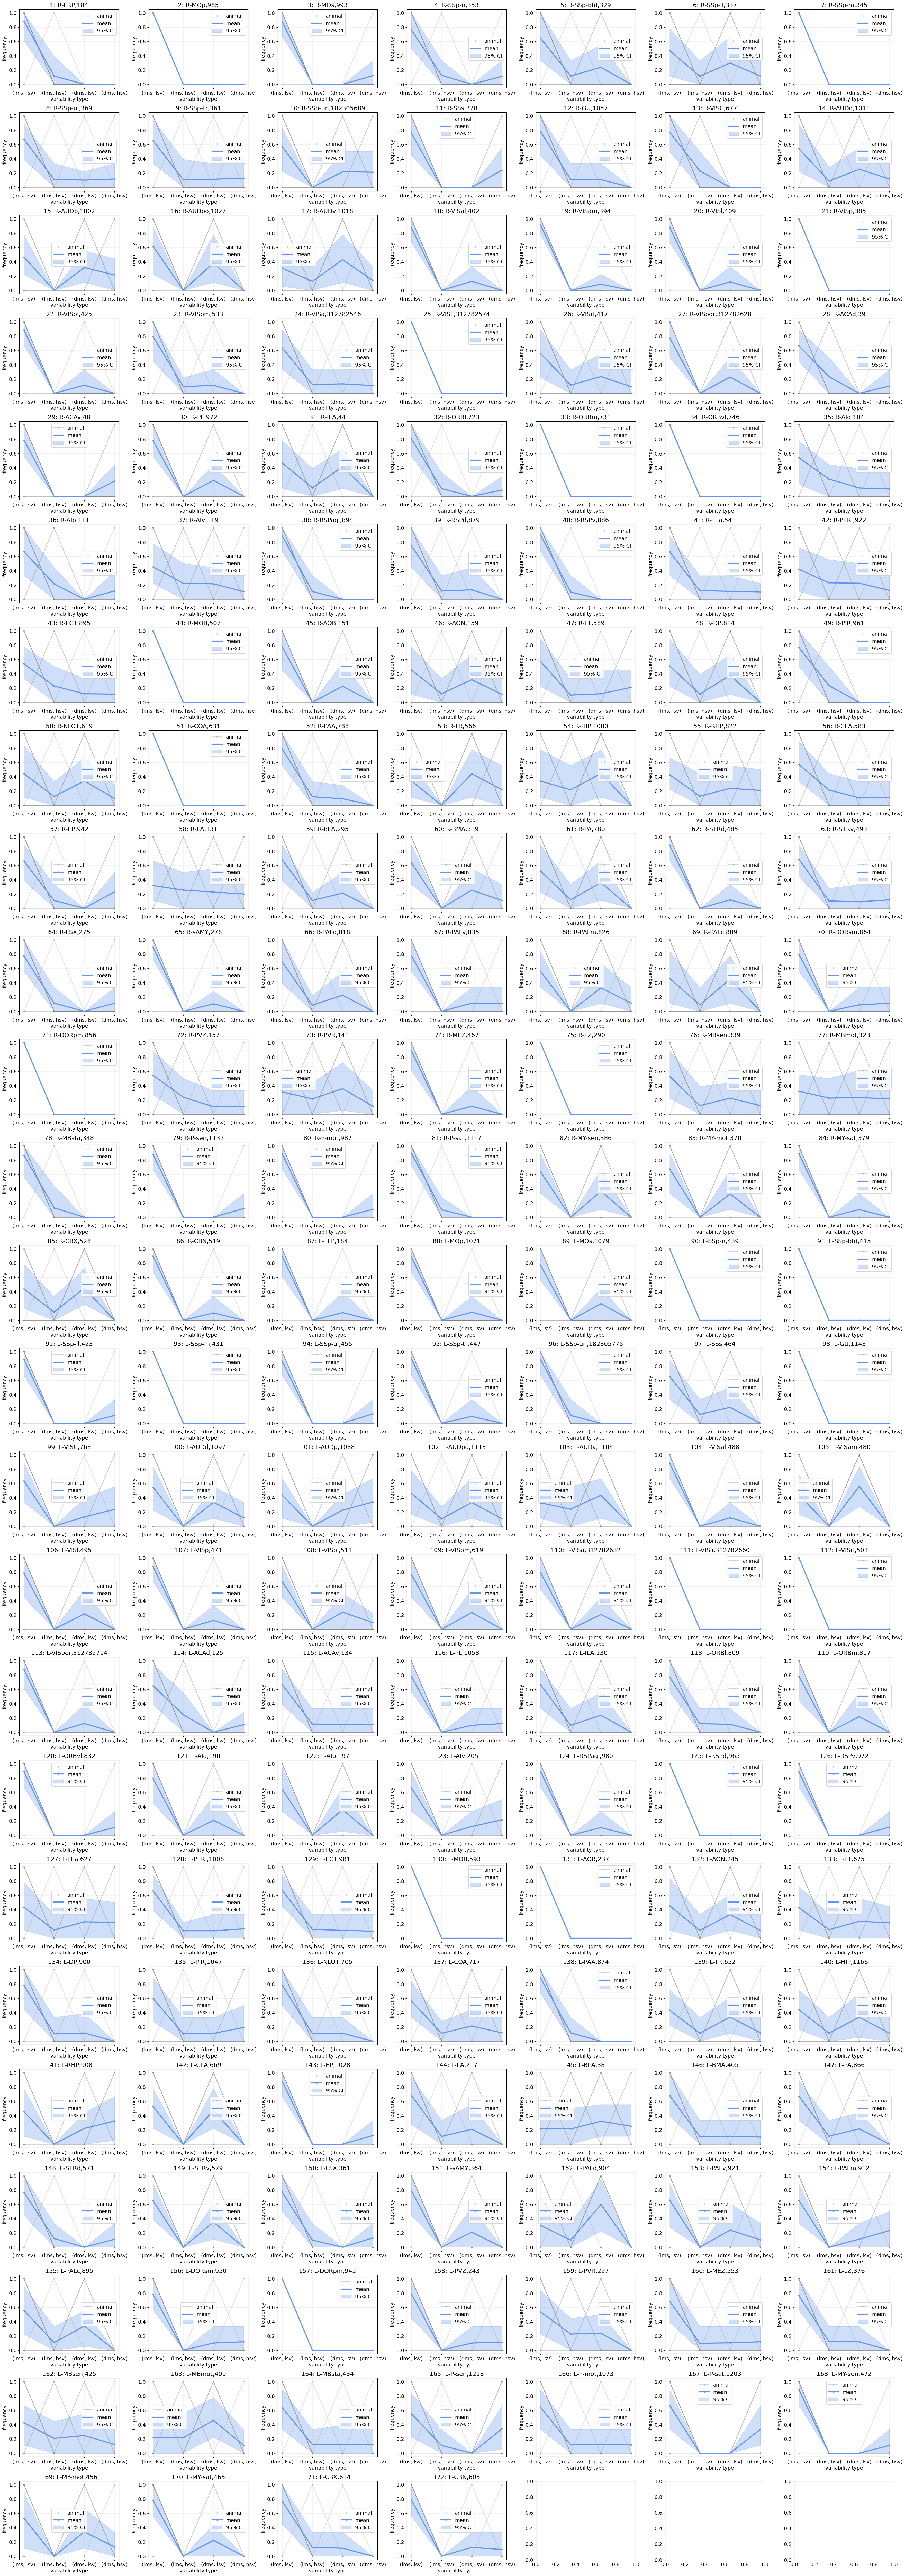

In [40]:
ncols = 7
nrows = np.ceil((vts.shape[0]) / ncols).astype(int)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
fig.tight_layout(h_pad=3, w_pad=3)

for idx_roi in range((vts.shape[0])):
    r, c, = idx_roi // ncols, idx_roi % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]

    X = vts[idx_roi, :, :]
    X_stat, X_ci = bootstrap(
        [X[:, i] for i in range(X.shape[-1])],
        statistic=np.mean,    
        n_bootstrap=100
    )

    ax.plot(range(X.shape[0]), X[:, 0], c='grey', marker='.', alpha=0.3, label='animal')
    ax.plot(range(X.shape[0]), X[:, 1:], c='grey', marker='.', alpha=0.3)
    ax.plot(range(X.shape[0]), X_stat, c='cornflowerblue', marker='.', linewidth=3, alpha=1, label='mean')
    ax.fill_between(
        range(X.shape[0]),
        y1=X_ci[0],
        y2=X_ci[1],
        color='cornflowerblue',
        alpha=0.3,
        label='95% CI',
    )
    ax.set(title=f'{idx_roi+1}: {roi_names[idx_roi]}', xlabel=f'variability type', ylabel=f'frequency')
    ax.set_xticks(range(X.shape[0]), ['(lms, lsv)', '(lms, hsv)', '(dms, lsv)', '(dms, hsv)'])
    ax.grid(alpha=0.15)
    ax.legend()


variability-types/profiles-nature per ic

In [41]:
col = cols[0]
col

'pi_0_aligned'

In [42]:
out_folder = f'{ESTIM_path}/individual/sub-*/consistency-of-comm-assignments/{SBM}/visuals/res-{args.resolution}/nii'
nii_files = sorted(glob.glob(f'{out_folder}/{col}_desc-var-types.nii.gz'))
nii_files

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/individual/sub-SLC01/consistency-of-comm-assignments/sbm-nd-h/visuals/res-200/nii/pi_0_aligned_desc-var-types.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/individual/sub-SLC03/consistency-of-comm-assignments/sbm-nd-h/visuals/res-200/nii/pi_0_aligned_desc-var-types.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/individual/sub-SLC04/consistency-of-comm-assignments/sbm-nd-h/visuals/res-200/nii/pi_0_aligned_desc-var-types.nii.gz'

In [43]:
# ic_files = sorted(glob.glob(f'{ROI_path}/canonical-systems/joanes/ics/both/*desc-*.nii.gz'))
ic_files = sorted(glob.glob(f'{SYS_path}/ics/both/*desc-*.nii.gz'))
# ics_df = pd.read_csv(f'{ROI_path}/canonical-systems/joanes/desc-ic-names.csv')
ics_df = pd.read_csv(f'{SYS_path}/desc-ic-names.csv')
ic_files

['/home/govindas/new_mouse_dataset/canonical_systems/joanes/space-ccfv2/ics/both/hemi-B_desc-00.nii.gz',
 '/home/govindas/new_mouse_dataset/canonical_systems/joanes/space-ccfv2/ics/both/hemi-B_desc-01.nii.gz',
 '/home/govindas/new_mouse_dataset/canonical_systems/joanes/space-ccfv2/ics/both/hemi-B_desc-02.nii.gz',
 '/home/govindas/new_mouse_dataset/canonical_systems/joanes/space-ccfv2/ics/both/hemi-B_desc-03.nii.gz',
 '/home/govindas/new_mouse_dataset/canonical_systems/joanes/space-ccfv2/ics/both/hemi-B_desc-04.nii.gz',
 '/home/govindas/new_mouse_dataset/canonical_systems/joanes/space-ccfv2/ics/both/hemi-B_desc-05.nii.gz',
 '/home/govindas/new_mouse_dataset/canonical_systems/joanes/space-ccfv2/ics/both/hemi-B_desc-06.nii.gz',
 '/home/govindas/new_mouse_dataset/canonical_systems/joanes/space-ccfv2/ics/both/hemi-B_desc-07.nii.gz',
 '/home/govindas/new_mouse_dataset/canonical_systems/joanes/space-ccfv2/ics/both/hemi-B_desc-08.nii.gz',
 '/home/govindas/new_mouse_dataset/canonical_systems/jo

In [44]:
ics_df

Unnamed: 0  ic           name            rsn
0            0   0            Pir      olfactory
1            1   1             M1        sensory
2            2   2  S1 (vlp) + S2  somatosensory
3            3   3   S1 (hl + fl)  somatosensory
4            4   4   S1 (fl + bf)  somatosensory
5            5   5        S1 (bf)  somatosensory
6            6   6       V2 + RSD        sensory
7            7   7     Au (d + v)        sensory
8            8   8            Cg2         limbic
9            9   9       Cg1 + RS         limbic
10          10  10         HP (v)         limbic
11          11  11         HP (d)         limbic
12          12  12            CPu  basal ganglia
13          13  13       CPu + En  basal ganglia
14          14  14  Sep + Pal (v)  basal ganglia
15          15  15           Amyg         limbic
16          16  16             Th         limbic
17          17  17        MO + GI      olfactory

In [45]:
def get_voxel_fractions(nii_vol, sys_vol):
    out_vol = nii_vol * sys_vol[..., np.newaxis]
    sys_size = np.count_nonzero(sys_vol)
    out_sizes = np.count_nonzero(out_vol, axis=(0, 1, 2))
    return np.nan_to_num(out_sizes / sys_size)

In [46]:
def get_voxel_fractions_all_sys(sys_files, ics_df, nii_files, ):
    vox_fracs_df = []
    for sys_file, (idx, row) in zip(sys_files, ics_df.iterrows()):
        sys_name = row['name']

        X = []
        for nii_file in nii_files:
            sub = [s for s in nii_file.split('/') if 'sub-' in s][0].split('-')[-1]
            vox_fracs = get_voxel_fractions(
                nii_vol=ants.image_read(nii_file).numpy(), 
                sys_vol=ants.image_read(sys_file).numpy(),
            )
            X += [vox_fracs]
        X = np.stack(X)
        df = pd.DataFrame({
            'animal': np.repeat(np.arange(1, len(nii_files)+1), 4),
            'var_type': np.tile(['(lms, lsv)', '(lms, hsv)', '(dms, lsv)', '(dms, hsv)'], len(nii_files)),
            'frac': X.flatten(),
        })
        vox_fracs_df += [
            pd.DataFrame(dict(
                sys=[sys_name],
                vox_fracs=[X],
                df=[df],
            ))
        ]
    vox_fracs_df = pd.concat(vox_fracs_df).reset_index(drop=True)
    return vox_fracs_df

In [47]:
vox_fracs_df = get_voxel_fractions_all_sys(ic_files, ics_df, nii_files)
vox_fracs_df

sys                                          vox_fracs  \
0             Pir  [[0.5498753117206983, 0.29087994299964376, 0.0...   
1              M1  [[0.6876122082585279, 0.017953321364452424, 0....   
2   S1 (vlp) + S2  [[0.9214790195263813, 0.0004154549231408392, 0...   
3    S1 (hl + fl)  [[0.7264784946236559, 0.12836021505376344, 0.1...   
4    S1 (fl + bf)  [[0.7538247566063978, 0.1780250347705146, 0.03...   
5         S1 (bf)  [[0.9051332033788174, 0.001299545159194282, 0....   
6        V2 + RSD  [[0.9891122278056952, 0.0041876046901172526, 0...   
7      Au (d + v)  [[0.7794441993824438, 0.008381120423467137, 0....   
8             Cg2  [[0.5950991831971996, 0.15227537922987164, 0.0...   
9        Cg1 + RS  [[0.5145299145299145, 0.1658119658119658, 0.2,...   
10         HP (v)  [[0.511295681063123, 0.0003322259136212625, 0....   
11         HP (d)  [[0.5032621589561092, 0.0, 0.21708185053380782...   
12            CPu  [[0.6562025316455696, 0.0015189873417721519, 0...   
13       CPu + En  [[0.5927099841521395, 0.021394611727416798, 0....   
14  Sep + Pal (v)  [[0.678949164107813, 0.07164790174002048, 0.12...   
15           Amyg  [[0.7574152542372882, 0.05985169491525424, 0.1...   
16             Th  [[0.6060744462205984, 0.0, 0.2105503539620918,...   
17        MO + GI  [[0.77751291219706, 0.08978943186332936, 0.092...   

                                                   df  
0       animal    var_type      frac
0        1  (...  
1       animal    var_type      frac
0        1  (...  
2       animal    var_type      frac
0        1  (...  
3       animal    var_type      frac
0        1  (...  
4       animal    var_type      frac
0        1  (...  
5       animal    var_type      frac
0        1  (...  
6       animal    var_type      frac
0        1  (...  
7       animal    var_type      frac
0        1  (...  
8       animal    var_type      frac
0        1  (...  
9       animal    var_type      frac
0        1  (...  
10      animal    var_type      frac
0        1  (...  
11      animal    var_type      frac
0        1  (...  
12      animal    var_type      frac
0        1  (...  
13      animal    var_type      frac
0        1  (...  
14      animal    var_type      frac
0        1  (...  
15      animal    var_type      frac
0        1  (...  
16      animal    var_type      frac
0        1  (...  
17      animal    var_type      frac
0        1  (...

In [48]:
# plot the types
def plot_var_types_all_sys(col, vox_fracs_df, ics_df):
    rsns = ics_df['rsn'].unique()

    ncols = 6
    nrows = len(ics_df['rsn'].unique())
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    fig.tight_layout(h_pad=3, w_pad=3)
    fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)

    full_labels = [
        'lms: localized membership per solution mode', 'dms: distributed membership per solution mode', 
        'lsv: low solution variability', 'hsv: high solution variability'
    ]
    handles = [plt.Line2D([], [], marker='_', color='w', markersize=12, label=label) for label in full_labels]

    col_idxs = np.zeros(len(rsns), dtype=int)
    for idx_sys, row in vox_fracs_df.iterrows():
        
        r = np.where(rsns == ics_df[ics_df['name'] == row['sys']]['rsn'].to_list()[0])[0][0] # find corresponding rsn
        c = col_idxs[r]
        col_idxs[r] = c+1
        ax = axs[r, c] if nrows > 1 else axs[c]
        
        X = row['vox_fracs']
        df = row['df']
        # print(row['sys'])
        # display(df)

        mean_X, ci = bootstrap([X[i, :] for i in range(X.shape[0])])

        sns.boxplot(df, x='var_type', y='frac', ax=ax, orient='v', color='grey', fill=False, fliersize=0, width=0.3, legend='brief')
        sns.stripplot(df, x='var_type', y='frac', ax=ax, orient='v', color='cornflowerblue', jitter=False)

        ax.plot(range(4), X[0, :], c='grey', alpha=0.3, label='animal')
        ax.plot(range(4), X[1:, :].T, c='grey', alpha=0.3)
        
        ax.plot(range(4), mean_X, c='cornflowerblue', label='mean')
        ax.fill_between(
            range(4),
            y1=ci[0],
            y2=ci[1],
            color='cornflowerblue',
            alpha=0.3,
            label=f'95% CI',
        )

        ax.set(title=f'IC: {row["sys"]}', ylim=[0, 1])
        if c == 0: 
            ax.set_ylabel(f'RSN: {rsns[r]} \n {ax.get_ylabel()}')
        ax.grid(alpha=0.15)
        ax.legend()
        # break



    for r in range(nrows):
        for c_ in range(col_idxs[r], ncols):
            ax = axs[r, c_]
            fig.delaxes(ax)

    fig.legend(handles=handles, loc='lower right', ncol=1)
    return fig




In [49]:
out_folder = f'{ESTIM_path}/group/consistency-of-comm-assignments/{SBM}/ics'
os.system(f'mkdir -p {out_folder}')
fig = plot_var_types_all_sys(col, vox_fracs_df, ics_df)
plt.close('all')
fig.savefig(f'{out_folder}/{col}_desc-var-types.pdf', bbox_inches='tight')

In [50]:
vox_fracs = np.stack(vox_fracs_df['vox_fracs'].to_list(), axis=-1)
vox_fracs.shape

(9, 4, 18)